### Kaggle - Web Traffic Time Series Forecasting

## Model 07 - Neural Network with Fibonacci 

### v0 initial

by Louis Yang

Use Fibonacci series median instead of median

Split into groups based on the scale of visit number and train individual model in each group

Original model "model_06_CNN_3_scale_group_5_more_group"

In [1]:
model_name = 'model_07_Neural_Network_with_Fibonacci'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

In [64]:
def arr_info(arr_list):
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

## Input

In [3]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


In [4]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [6]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [7]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

In [8]:
X_input_first_day = input_df.columns[-x_length-y_length-364]
X_input_final_day = input_df.columns[-1-y_length-364]
X_input_first_day, X_input_final_day

('2015-08-30', '2015-10-31')

In [9]:
daydiff(X_input_first_day, X_input_final_day)

datetime.timedelta(-62)

In [10]:
X_output_first_day = input_df.columns[-x_length-y_length]
X_output_final_day = input_df.columns[-1-y_length]
X_output_first_day, X_output_final_day

('2016-08-28', '2016-10-29')

In [11]:
daydiff(X_output_first_day, X_output_final_day)

datetime.timedelta(-62)

In [12]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

Y_output_first_day = '2017-01-01'; Y_output_final_day = '2017-03-01'
daydiff(Y_output_first_day,Y_output_final_day)

In [13]:
Y_input_first_day = input_df.columns[-364-y_length]
Y_input_final_day = input_df.columns[-1-364]
Y_input_first_day, Y_input_final_day

('2015-11-01', '2016-01-02')

In [14]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [15]:
Y_output_first_day = input_df.columns[-y_length]
Y_output_final_day = input_df.columns[-1]
Y_output_first_day, Y_output_final_day

('2016-10-30', '2016-12-31')

In [16]:
daydiff(Y_output_first_day, Y_output_final_day)

datetime.timedelta(-62)

In [17]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

## Fibonacci

Here we use all input data for computing Fibonacci median, which includes the test set Y. However, in the actual predicting stage we will not have the future data. So this must be changed.

In [24]:
fib_dates = input_df.columns[1:]; fib_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [26]:
fib_data = input_df[fib_dates].values; fib_data

array([[ 18.,  11.,   5., ...,  19.,  18.,  20.],
       [ 11.,  14.,  15., ...,  45.,  26.,  20.],
       [  1.,   0.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

### Find starting dates

In [35]:
start_tf = ~np.isnan(fib_data); start_tf

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [42]:
fib_days = len(fib_data[0]); fib_days

550

In [55]:
index_range = np.arange(fib_days)
def first_true_index(x):
    temp = index_range[x]
    if temp.any():
        return temp[0]
    else:
        return -1
#first_true_index_v = np.vectorize(first_true_index)

In [56]:
start_index = np.array([first_true_index(x) for x in start_tf])

In [57]:
start_index

array([ 0,  0,  0, ..., -1, -1, -1])

### Window

In [18]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]

In [70]:
fib_view_list = [fib_data[:, -w:] for w in windows]

In [77]:
fib_median_list = np.array([np.nanmedian(view, axis=-1) for view in fib_view_list])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [209]:
fib_median_list.T.shape

(145063, 8)

In [81]:
fib_median_na = np.nanmedian(fib_median_list_a.T, axis=-1)

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [83]:
fib_median_na

array([ 18.25,  21.5 ,   4.  , ...,    nan,    nan,    nan])

In [86]:
fib_median = np.nan_to_num(fib_median_na); fib_median.shape

(145063,)

In [85]:
fib_median

array([ 18.25,  21.5 ,   4.  , ...,   0.  ,   0.  ,   0.  ])

We will use this as the center

### Data range reduce
Select x_length + y_length days of data as training set

where x_length = 60, y_length = 60 by default for training set 1.

In [87]:
X_input_first_day, Y_input_final_day

('2015-08-30', '2016-01-02')

input_data contains X_input and Y_input array

In [88]:
input_date_range = input_df.columns[-x_length-y_length-364:-364]; input_date_range

Index(['2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
       '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08',
       ...
       '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
       '2015-12-29', '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02'],
      dtype='object', length=126)

In [89]:
input_data = input_df[input_date_range].values; #input_data

In [90]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[  9.,  10.,   9., ...,  18.,   9.,  16.],
       [ 22.,  11.,  81., ...,   9.,   7.,  15.],
       [  1.,   3.,   4., ...,   2.,   2.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [91]:
input_data_num.shape

(145063, 126)

In [92]:
X_output_first_day, Y_output_final_day

('2016-08-28', '2016-12-31')

output_data for this self-testing script contains both X_output and Y_output

In [93]:
output_date_range = input_df.columns[-x_length-y_length:]; output_date_range

Index(['2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01',
       '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=126)

In [94]:
output_data = input_df[output_date_range].values; #output_data

In [95]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [96]:
output_data_num.shape

(145063, 126)

### View

In [97]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [98]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [99]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [100]:
output_data_log.shape, output_data.shape

((145063, 126), (145063, 126))

In [101]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [102]:
input_data_log

array([[ 1.        ,  1.04139269,  1.        , ...,  1.2787536 ,
         1.        ,  1.23044892],
       [ 1.36172784,  1.07918125,  1.91381385, ...,  1.        ,
         0.90308999,  1.20411998],
       [ 0.30103   ,  0.60205999,  0.69897   , ...,  0.47712125,
         0.47712125,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [103]:
output_data_log

array([[ 1.2787536 ,  1.43136376,  0.95424251, ...,  1.30103   ,
         1.2787536 ,  1.32221929],
       [ 1.41497335,  1.36172784,  2.161368  , ...,  1.66275783,
         1.43136376,  1.32221929],
       [ 0.60205999,  0.77815125,  0.69897   , ...,  0.60205999,
         0.69897   ,  1.25527251],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [104]:
# Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

(-1.862645149230957e-08, 1.862645149230957e-08)

In [105]:
# Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

(-2.9802322387695313e-08, 2.6077032089233398e-08)

### Normalization (Shift and Scale)

#### Use fib median instead

In [109]:
input_center = log(fib_median).reshape(-1,1)
output_center = log(fib_median).reshape(-1,1)

In [110]:
input_center

array([[ 1.28443073],
       [ 1.35218252],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

#### Compute Median and Stdev

In [111]:
np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)

array([[ 1.04139269],
       [ 1.23044892],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [112]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.22974401],
       [ 0.23685744],
       [ 0.27363311],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [113]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.19725496],
       [ 0.25052371],
       [ 0.21878369],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

In [114]:
# Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

array([], dtype=float64)

In [115]:
# Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

array([], dtype=float64)

#### Transform by Median and Stdev

In [116]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [117]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [118]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [119]:
check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

([], [])

In [120]:
# Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [121]:
# Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

## Scale Investigation

#### Input median

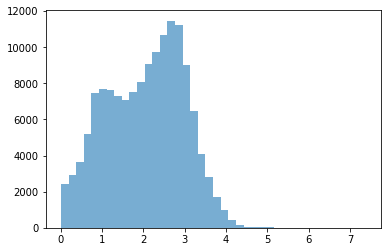

In [126]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.show()

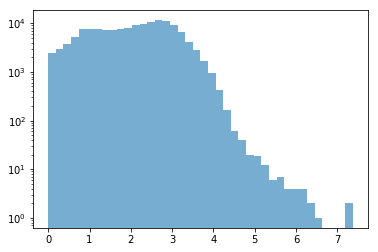

In [123]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output median

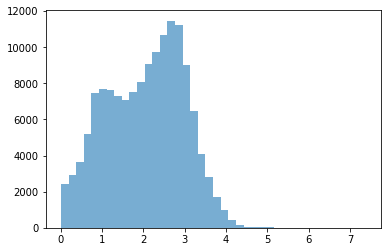

In [127]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.show()

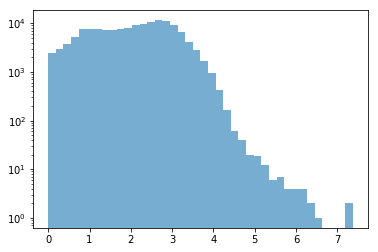

In [125]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input std

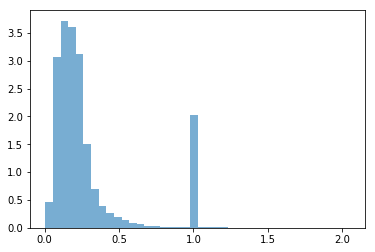

In [128]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

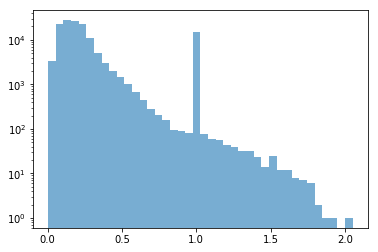

In [129]:
plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output std

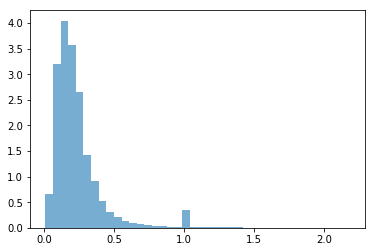

In [130]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

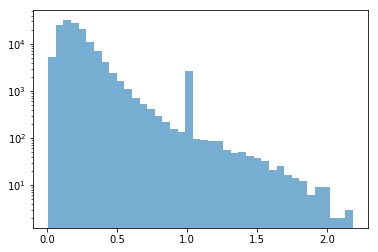

In [131]:
plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [132]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [133]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([2, 2, 1, ..., 0, 0, 0]), array([2, 2, 1, ..., 0, 0, 0]))

In [134]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[2291, 22088, 41343, 78354, 927, 60]

In [139]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[2291, 22088, 41343, 78354, 927, 60]

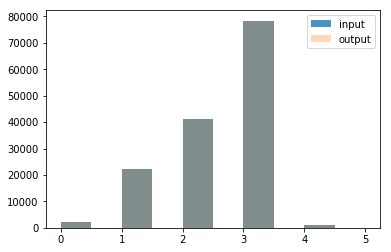

In [135]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

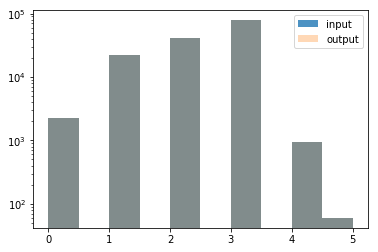

In [136]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

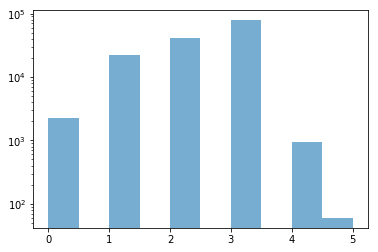

In [137]:
plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

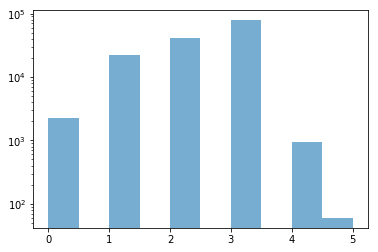

In [138]:
plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [140]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [141]:
X_output = output_data_norm[:, :x_length]
Y_output = output_data_norm[:, -y_length:]
X_output.shape, Y_output.shape

((145063, 63), (145063, 63))

#### Original data

In [142]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
Y_output_ori = output_data_num[:, -y_length:]

#### Backward compatible

In [143]:
X_train = X_input
Y_train = Y_input

In [144]:
X_val = X_output
Y_val = Y_output

In [145]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
Y_val_ori = Y_output_ori

In [146]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_scale

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

Y_output, output_data_norm[:,-y_length:]

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

Y_output_ori, output_data_num

In [147]:
arr_info((X_input, Y_input, X_output, Y_output, 
          X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))

(145063, 63) -106.152348974 73.6664023257 -0.508183448009 3.12074331353
(145063, 63) -106.152348974 83.3110546554 -0.326078841514 3.06404144077
(145063, 63) -101.560690708 32.1491882006 -0.00675739551681 1.83762826511
(145063, 63) -101.560690708 92.8888263248 0.0 1.73450982213
(145063, 63) 0.0 21553554.0 75.0 64150.7195046
(145063, 63) 0.0 21366420.0 88.0 62373.0578871
(145063, 63) 0.0 33446984.0 139.0 87516.7023757
(145063, 63) 0.0 28342885.0 143.0 81329.6278471


### Split Data into Training and (Pseudo) Cross Validation Sets
Not using this. Use keras built-in feature for pseudo validation

def make_shuffle_index(n, seed=None):
    shuffle_index = np.array(list(range(n)))
    np.random.seed(seed)  # you can fix the initial seed for comparison purpose
    np.random.shuffle(shuffle_index)
    return shuffle_index

def using(array_ori, index_list):
    #return np.array([array_ori[i] for i in index_list])
    return np.take(array_ori, index_list, axis=0)

#Generate a shuffle list
shuffle_index = make_shuffle_index(len(X_input), seed=123)

Keep 10% of input data as validation set

#Split the index list into training and validation sets
n_val = int(len(X_input) * 0.1)
val_index = shuffle_index[:n_val]
train_index = shuffle_index[n_val:]

#Split the data sets according to the index list
X_train = using(X_input, train_index)
Y_train = using(Y_input, train_index)
X_val = using(X_input, val_index)
Y_val = using(Y_input, val_index)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

#### Split the untransformed data
Split the untransformed data in the same way for score estimation

train_data_num = using(input_data_num, train_index)
val_data_num = using(input_data_num, val_index)

X_train_ori, Y_train_ori = make_XY(train_data_num)
X_val_ori, Y_val_ori = make_XY(val_data_num)
X_train_ori.shape, Y_train_ori.shape, X_val_ori.shape, Y_val_ori.shape

train_center = using(input_center, train_index)
val_center = using(input_center, val_index)
train_scale = using(input_scale, train_index)
val_scale = using(input_scale, val_index)
train_center.shape, val_center.shape, train_scale.shape, val_scale.shape

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [148]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]

In [149]:
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [150]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [151]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [152]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.mean(diff, axis=axis)

In [153]:
# Benchmark SMAPE on the transformed data
smape(Y_train,X_train), smape(Y_val,X_val), smape(Y_train,Y_train)

(102.71719101890298, 141.1747271113145, 0.0)

In [154]:
# Benchmark SMAPE on the original data
smape(Y_train_ori,X_train_ori), smape(Y_val_ori,X_val_ori), \
smape(Y_train_ori,Y_train_ori)

(51.874930937113326, 57.677220315844565, 0.0)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [155]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape

In [157]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(60, kernel_size=5, activation='relu')(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 63)                0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 63, 1)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 59, 60)            360       
_________________________________________________________________
flatten_7 (Flatten)          (None, 3540)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)               424920    
_________________________________________________________________
dropout_13 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 120)               14520     
_

About 22s for 1 epoch on i5-750 CPU

In [159]:
len(gp_list)

6

In [160]:
epochs_list = [40,40,40,40,60,80]

In [161]:
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 2176 samples, validate on 115 samples
Epoch 1/40
2s - loss: 6.3262 - k_smape: 185.6852 - val_loss: 0.8935 - val_k_smape: 192.0353
Epoch 2/40
0s - loss: 5.3607 - k_smape: 190.5547 - val_loss: 0.5989 - val_k_smape: 191.0437
Epoch 3/40
0s - loss: 4.3009 - k_smape: 189.4588 - val_loss: 0.4935 - val_k_smape: 190.3312
Epoch 4/40
0s - loss: 3.6014 - k_smape: 188.5876 - val_loss: 0.3235 - val_k_smape: 189.6269
Epoch 5/40
0s - loss: 3.0252 - k_smape: 188.9117 - val_loss: 0.2239 - val_k_smape: 188.0167
Epoch 6/40
0s - loss: 2.7759 - k_smape: 187.3247 - val_loss: 0.2199 - val_k_smape: 189.0146
Epoch 7/40
0s - loss: 2.9953 - k_smape: 187.7625 - val_loss: 0.2027 - val_k_smape: 188.6845
Epoch 8/40
0s - loss: 3.5197 - k_smape: 188.2995 - val_loss: 0.4119 - val_k_smape: 189.7091
Epoch 9/40
0s - loss: 2.6051 - k_smape: 187.3817 - val_loss: 0.5027 - val_k_smape: 190.7622
Epoch 10/40
0s - loss: 2.5604 - k_smape: 187.0761 - val_loss: 0.1931 - val_k_smape: 188.2274
Epoch 11/40
0s - loss: 

6s - loss: 2.2081 - k_smape: 107.3958 - val_loss: 1.0073 - val_k_smape: 126.1287
Epoch 9/40
6s - loss: 2.3559 - k_smape: 106.6168 - val_loss: 1.0081 - val_k_smape: 124.9072
Epoch 10/40
6s - loss: 2.1476 - k_smape: 105.7514 - val_loss: 1.0337 - val_k_smape: 128.7793
Epoch 11/40
6s - loss: 2.1384 - k_smape: 105.4100 - val_loss: 1.0538 - val_k_smape: 131.1124
Epoch 12/40
6s - loss: 2.0309 - k_smape: 105.4400 - val_loss: 1.0195 - val_k_smape: 127.9424
Epoch 13/40
6s - loss: 2.3089 - k_smape: 105.3393 - val_loss: 1.0595 - val_k_smape: 131.0124
Epoch 14/40
6s - loss: 2.0903 - k_smape: 104.5600 - val_loss: 1.0073 - val_k_smape: 127.6773
Epoch 15/40
6s - loss: 2.0403 - k_smape: 104.5531 - val_loss: 1.0352 - val_k_smape: 129.1240
Epoch 16/40
6s - loss: 2.2121 - k_smape: 104.7533 - val_loss: 1.0522 - val_k_smape: 123.0580
Epoch 17/40
6s - loss: 2.0552 - k_smape: 103.9296 - val_loss: 1.0215 - val_k_smape: 122.5586
Epoch 18/40
6s - loss: 2.0007 - k_smape: 104.0293 - val_loss: 1.0092 - val_k_smape:

0s - loss: 8.4876 - k_smape: 89.0239 - val_loss: 2.4905 - val_k_smape: 85.5922
Epoch 18/60
0s - loss: 9.7978 - k_smape: 92.9246 - val_loss: 3.0785 - val_k_smape: 89.1686
Epoch 19/60
0s - loss: 8.7957 - k_smape: 89.7268 - val_loss: 2.2000 - val_k_smape: 78.0019
Epoch 20/60
0s - loss: 9.1008 - k_smape: 88.3366 - val_loss: 3.2096 - val_k_smape: 89.3540
Epoch 21/60
0s - loss: 10.1796 - k_smape: 88.6113 - val_loss: 2.2488 - val_k_smape: 78.0719
Epoch 22/60
0s - loss: 10.1879 - k_smape: 90.2572 - val_loss: 3.5878 - val_k_smape: 91.0776
Epoch 23/60
0s - loss: 10.7836 - k_smape: 85.5183 - val_loss: 2.2805 - val_k_smape: 78.2666
Epoch 24/60
0s - loss: 8.3252 - k_smape: 89.3526 - val_loss: 2.8785 - val_k_smape: 90.1941
Epoch 25/60
0s - loss: 8.8529 - k_smape: 85.1116 - val_loss: 1.9239 - val_k_smape: 77.0280
Epoch 26/60
0s - loss: 7.4503 - k_smape: 87.1364 - val_loss: 2.5157 - val_k_smape: 82.9178
Epoch 27/60
0s - loss: 8.8361 - k_smape: 83.6477 - val_loss: 2.1428 - val_k_smape: 78.3588
Epoch 28

0s - loss: 37.0155 - k_smape: 72.6549 - val_loss: 3.9465 - val_k_smape: 124.4385
Epoch 54/80
0s - loss: 37.9852 - k_smape: 73.0412 - val_loss: 3.9551 - val_k_smape: 124.5643
Epoch 55/80
0s - loss: 40.6261 - k_smape: 74.5430 - val_loss: 3.9397 - val_k_smape: 124.0964
Epoch 56/80
0s - loss: 32.9959 - k_smape: 71.8757 - val_loss: 3.9171 - val_k_smape: 123.1628
Epoch 57/80
0s - loss: 36.6634 - k_smape: 74.3048 - val_loss: 3.8945 - val_k_smape: 121.9740
Epoch 58/80
0s - loss: 39.0368 - k_smape: 72.4540 - val_loss: 3.8424 - val_k_smape: 120.2734
Epoch 59/80
0s - loss: 38.1853 - k_smape: 67.2763 - val_loss: 3.8479 - val_k_smape: 120.6421
Epoch 60/80
0s - loss: 37.9450 - k_smape: 69.1387 - val_loss: 3.9478 - val_k_smape: 123.1072
Epoch 61/80
0s - loss: 36.0455 - k_smape: 69.0704 - val_loss: 4.1547 - val_k_smape: 128.1908
Epoch 62/80
0s - loss: 35.0618 - k_smape: 71.1338 - val_loss: 4.4770 - val_k_smape: 136.5307
Epoch 63/80
0s - loss: 32.2432 - k_smape: 73.7062 - val_loss: 4.6906 - val_k_smape

### Training History

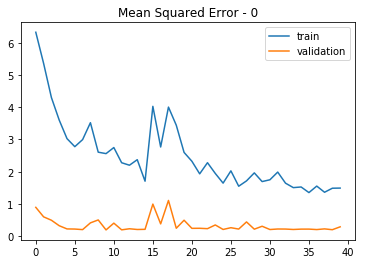

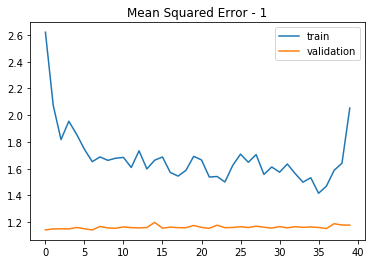

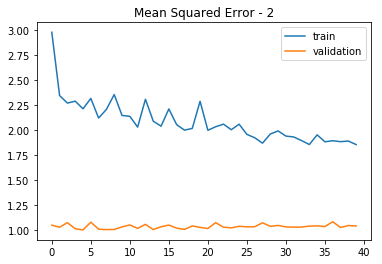

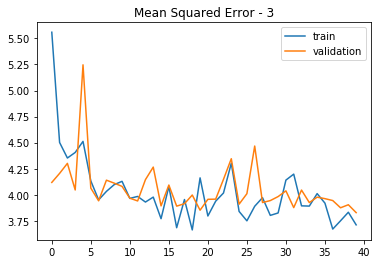

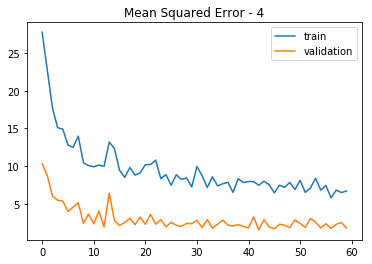

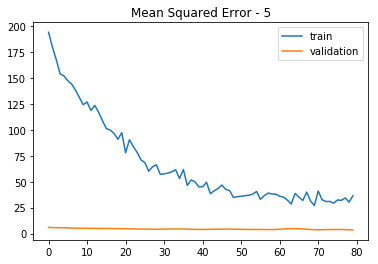

In [162]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Mean Squared Error - ' + str(gp))
    plt.legend(); plt.show()

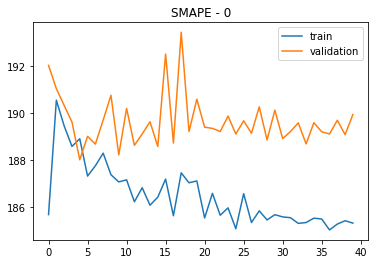

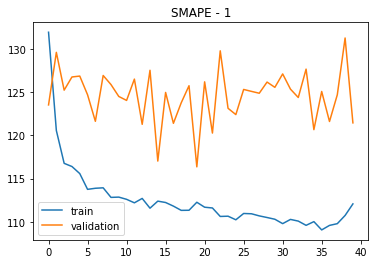

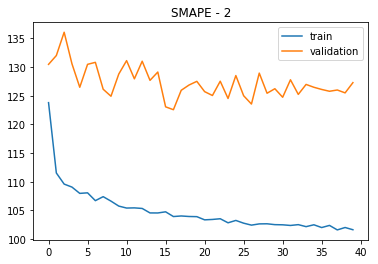

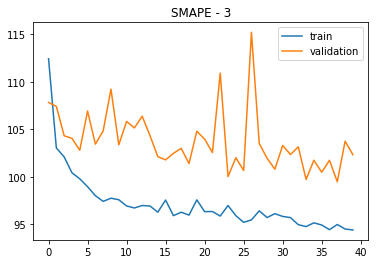

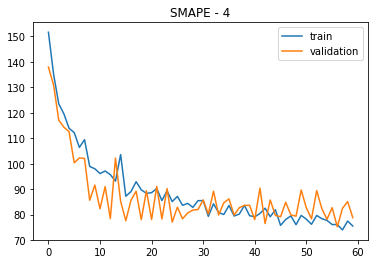

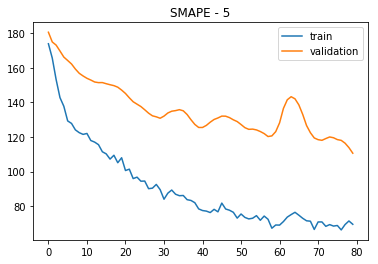

In [163]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label='train')
    plt.plot(hist.history['val_k_smape'], label='validation')
    plt.title('SMAPE - ' + str(gp))
    plt.legend(); plt.show()

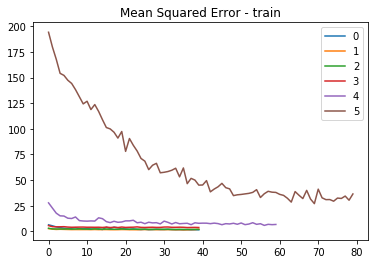

In [164]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

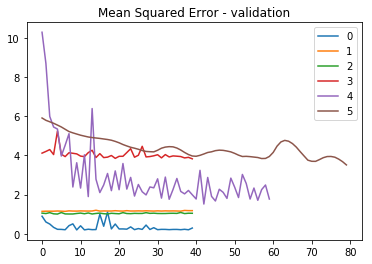

In [165]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

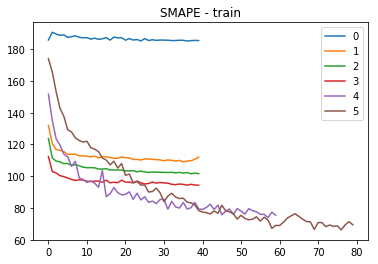

In [166]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

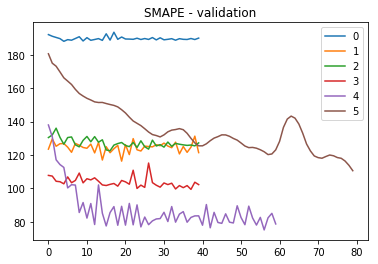

In [167]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using for Output Set

In [168]:
for (gp, model, X, Y) in zip(gp_list, models, 
                             X_output_list, Y_output_list):
    print()
    print(model.evaluate(X,Y))


1792/2291 [======================>.......] - ETA: 0s[2.6016466753002025, 189.72396760005608]

21952/22088 [============================>.] - ETA: 0s[2.110509069468482, 151.60127791888641]

40896/41343 [============================>.] - ETA: 0s[2.4384489511309204, 145.11177642920441]

78354/78354 [==============================] - 5s     
[3.8621289428039858, 133.70384494321806]

736/927 [======================>.......] - ETA: 0s[6.3739954594526731, 133.61913670742524]

32/60 [===============>..............] - ETA: 0s[15.577379409472147, 129.07357126871744]


### Predict for Output Set

In [169]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4
5


Find the original index

In [170]:
len(output_gp)

145063

In [171]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [172]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [173]:
for o in output_index_list:
    print(o.shape)

(2291,)
(22088,)
(41343,)
(78354,)
(927,)
(60,)


In [174]:
output_index_list_comb = np.concatenate(output_index_list)

In [175]:
output_index_list_comb

array([    54,    117,    148, ..., 123025, 139119, 140151])

In [176]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [177]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [178]:
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

In [179]:
Y_output_pred

array([[-0.3302905 , -0.18844131, -0.16678137, ..., -0.34839034,
        -0.30219251, -0.09660955],
       [ 0.05114043,  0.07209575,  0.09998128, ..., -0.05924755,
         0.0674108 ,  0.26961488],
       [-0.36797041, -0.36427858, -0.22654659, ..., -0.21280187,
        -0.32239565, -0.15667409],
       ..., 
       [ 0.05371452,  0.05736075,  0.03370935, ...,  0.14059098,
         0.11437912,  0.16277856],
       [ 0.05371452,  0.05736075,  0.03370935, ...,  0.14059098,
         0.11437912,  0.16277856],
       [ 0.05371452,  0.05736075,  0.03370935, ...,  0.14059098,
         0.11437912,  0.16277856]], dtype=float32)

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(Y_output_pred_ori[28450])

## Test

Y_output_ori = output_data_num[:,-y_length:]

In [180]:
# SMAPE of the real test set
smape(Y_output_ori, Y_output_pred_ori)

48.370861151366526

In [181]:
model_name

'model_07_Neural_Network_with_Fibonacci'

In [183]:
epochs_list#, epochs_list2

[40, 40, 40, 40, 60, 80]

SMAPE:

50.523 - Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.516 - Model 6.0.1 CNN - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.686 - Model 6.3.0 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.265 - Model 6.3.1 - (40,40,40,60,60) epoches

50.289 - Model 6.3.1 - (40,40,40,60,60) epoches, run 2

51.017 - Model 6.3.2 - (20,40,20,80,80) epoches

50.773 - Model 6.3.3 group by scale (= 0.,< 1.4,< 2.5,< 3.8,) - (20,30,20,20,30) epoches

50.434 - Model 6.3.4 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,60,60) epoches

50.283 - Model 6.3.5 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

50.923 - Model 6.3.6 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

50.895 - Model 6.3.7 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 5)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

48.371 - Model 7.0.0 Fibonacci - group(= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 5)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

## Group Scores

output_center_list = [output_center[output_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

In [184]:
Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

In [185]:
for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
    print(smape(Y, Y_p), len(Y))

190.602732218 2291
75.9952943646 22088
42.6923415854 41343
39.4100029834 78354
50.2676218498 927
33.4728730331 60


In [186]:
tot_n = len(output_gp); tot_n

145063

In [187]:
tot_n = len(output_gp)
x_tmp = 0.
for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * len(Y)
    print(s_tmp / tot_n)
    x_tmp += s_tmp
x_tmp / tot_n

3.01021528241
11.5714142264
12.1673305954
21.2868296792
0.321226539192
0.0138448286743


48.370861151366547

Filter size| 3| 5| 7| Fib 5
-|-|-|-|-
0| 7.539| 7.590	| 7.582| 3.010
1| 9.722| 9.855	| 9.776|11.571
2|12.666|12.886	|13.033|12.167
3|20.117|20.323	|20.295|21.287
4| 0.225| 0.226	| 0.223| 0.321
5| 0.015| 0.014	| 0.014| 0.014
Total| 50.283| 50.895| 50.922| 48.371

## Compare

Y_input_ori = input_data[:,-y_length:]
X_input_ori = input_data[:,:x_length]
X_output_ori = output_data[:,:x_length]

In [188]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True):
    for x in x_list:
        plt.plot(x)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i))
    return list(view_list)

view_list = None

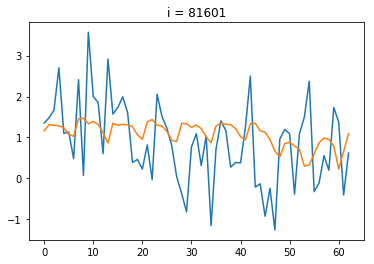

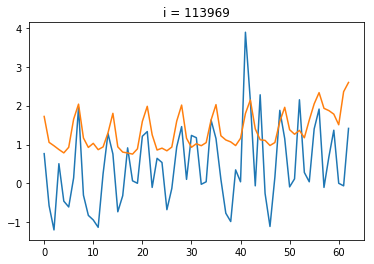

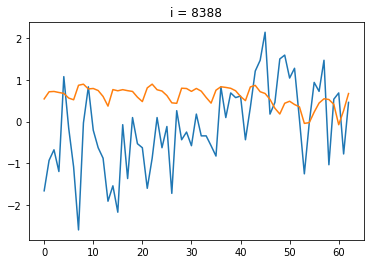

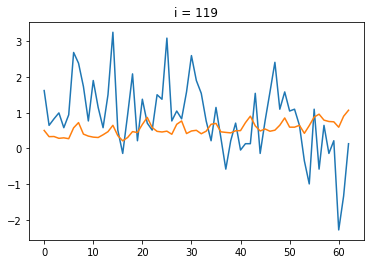

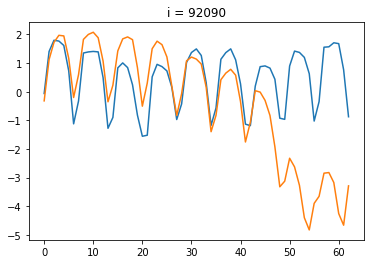

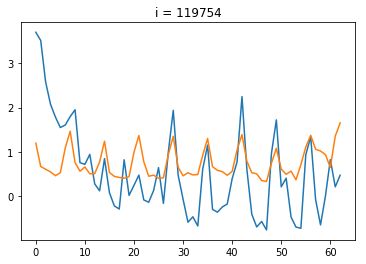

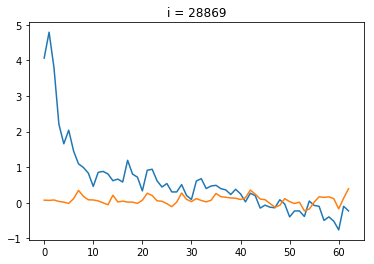

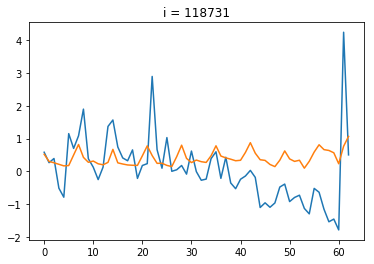

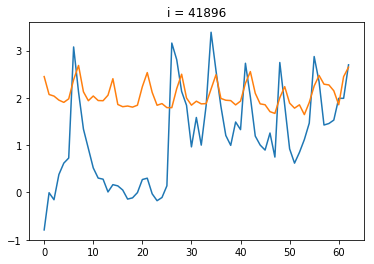

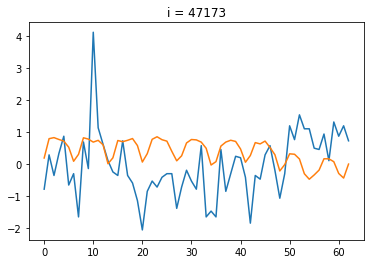

In [189]:
view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [190]:
view_list

[81601, 113969, 8388, 119, 92090, 119754, 28869, 118731, 41896, 47173]

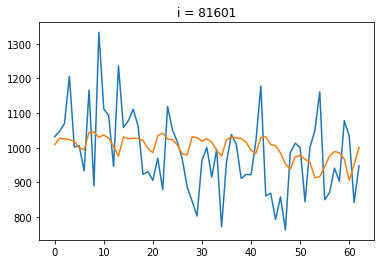

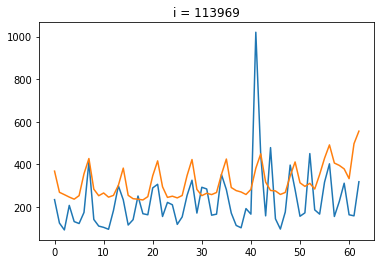

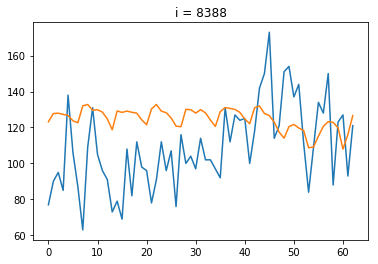

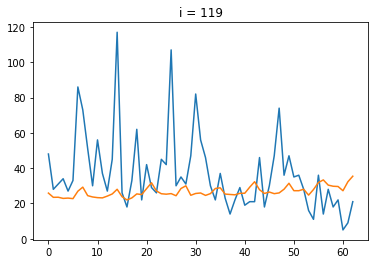

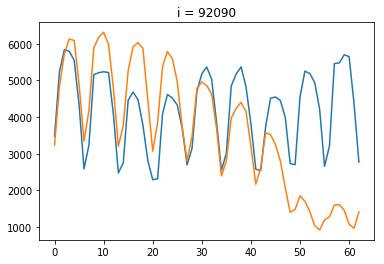

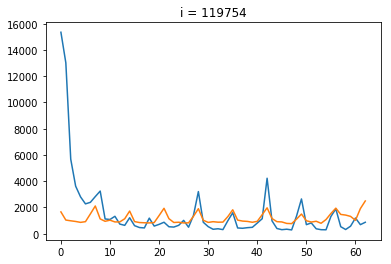

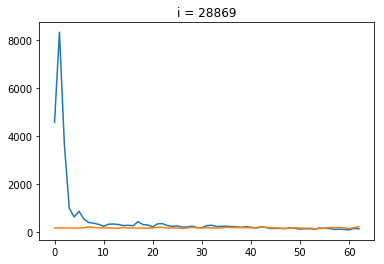

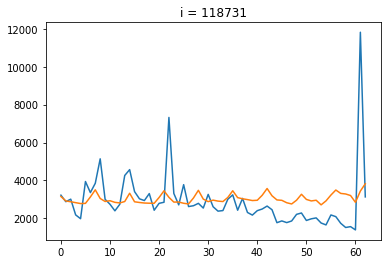

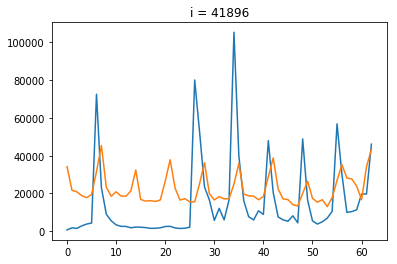

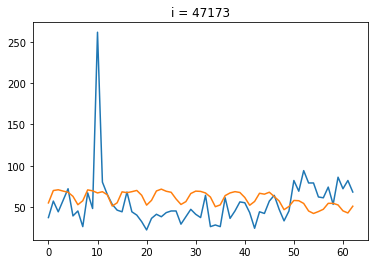

In [191]:
view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

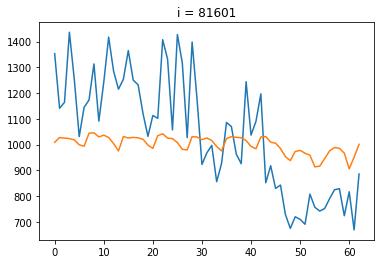

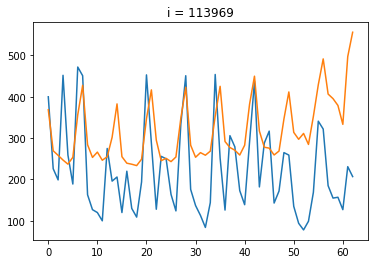

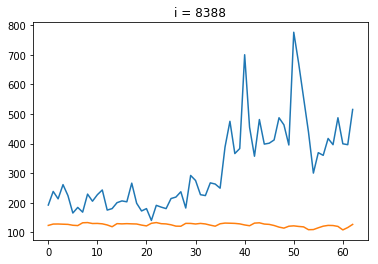

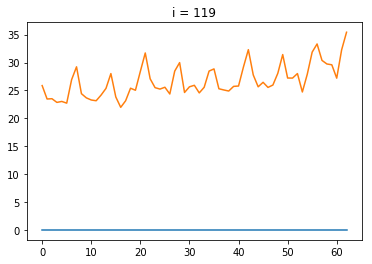

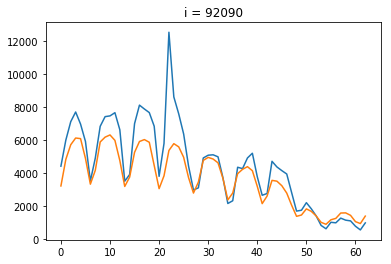

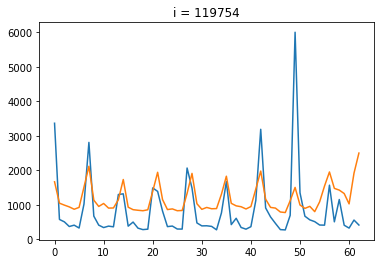

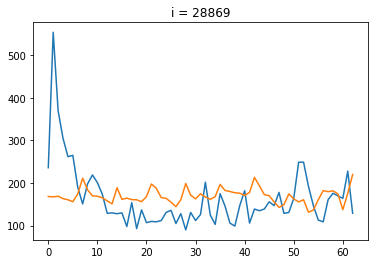

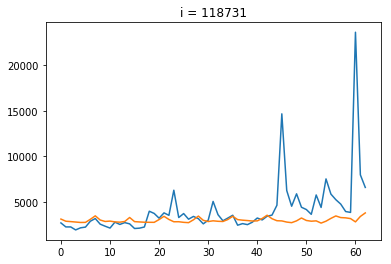

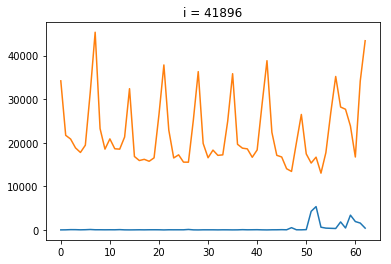

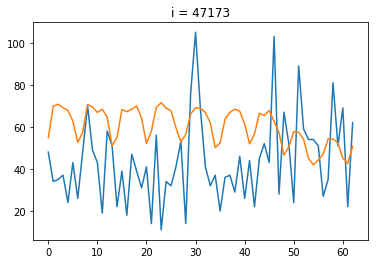

In [192]:
view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

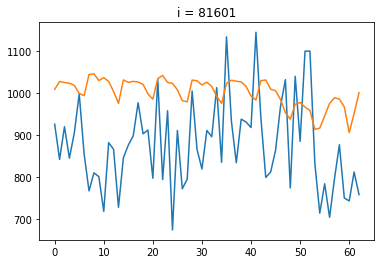

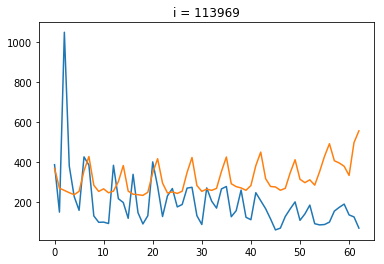

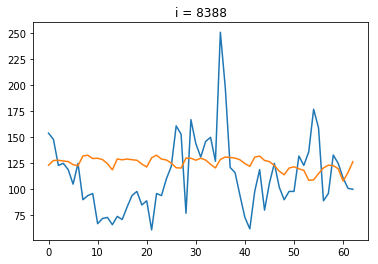

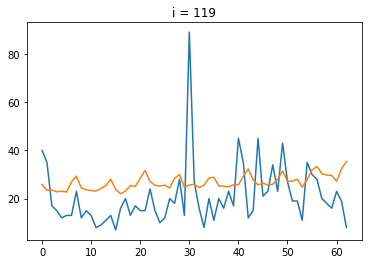

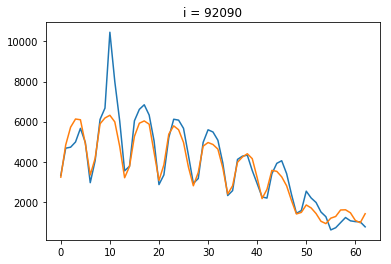

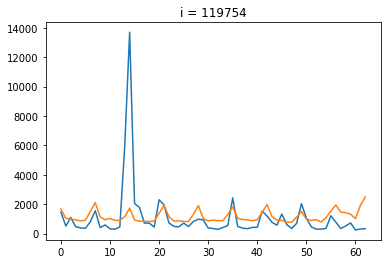

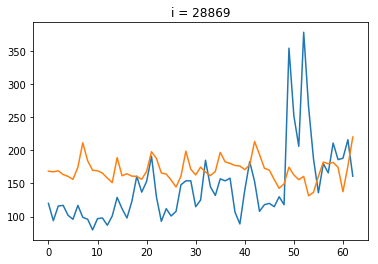

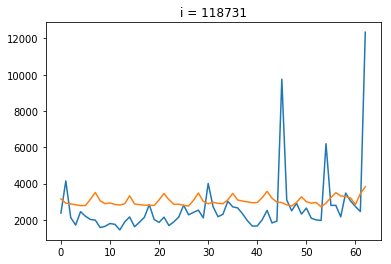

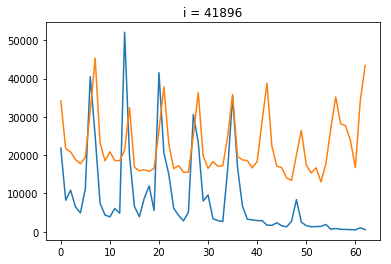

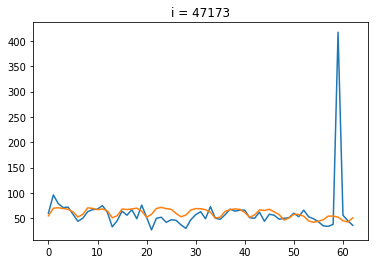

In [193]:
view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

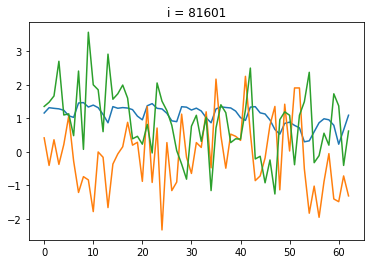

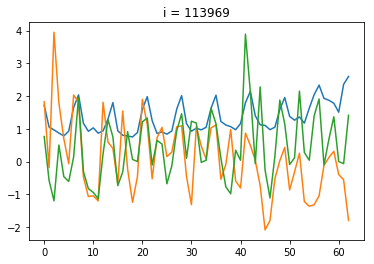

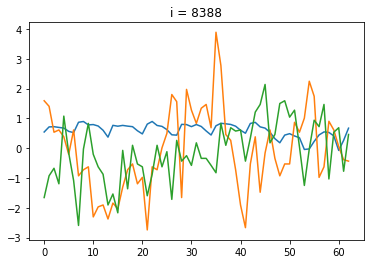

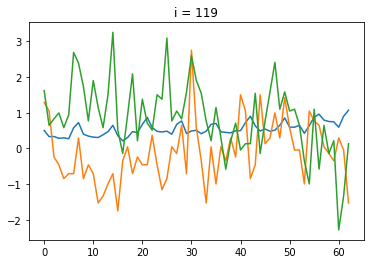

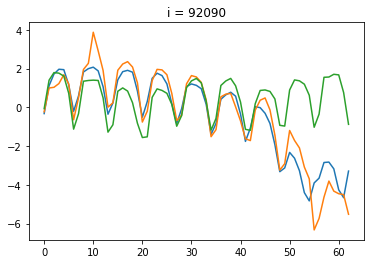

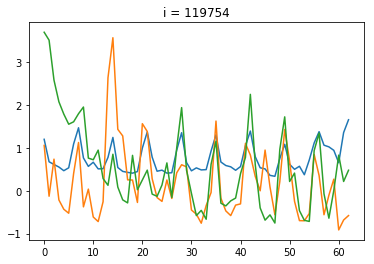

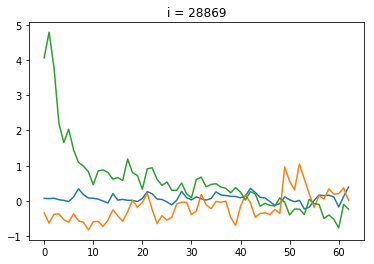

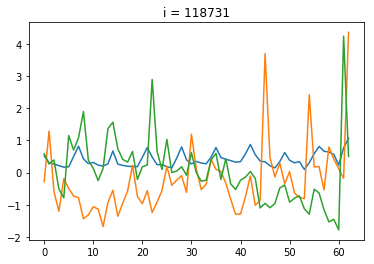

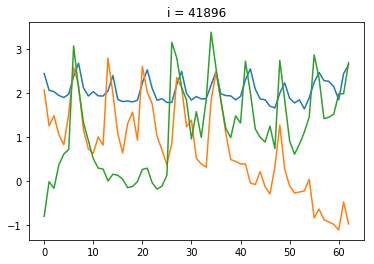

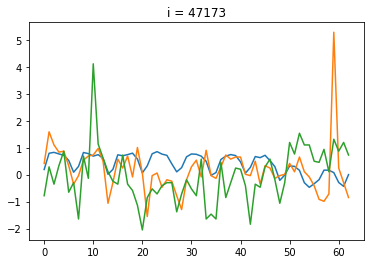

In [194]:
view_list = examine_list((Y_output_pred, Y_output, X_output), 
                         view_list=view_list)

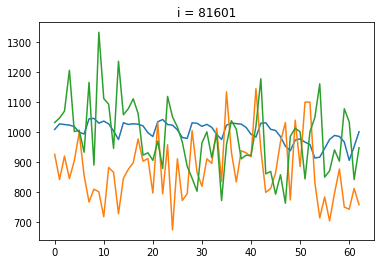

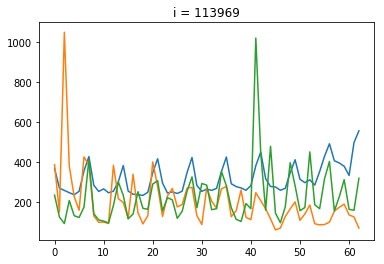

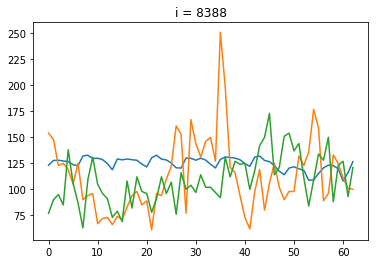

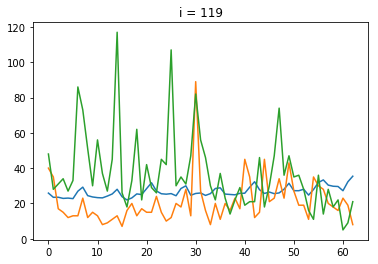

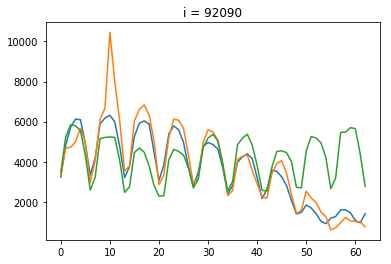

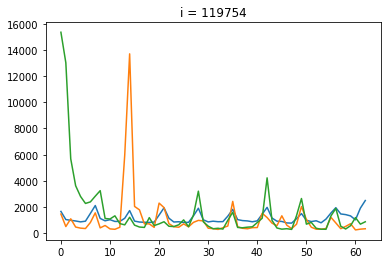

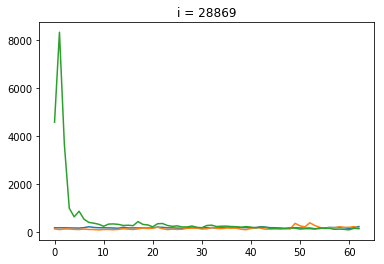

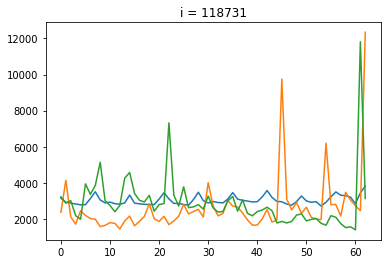

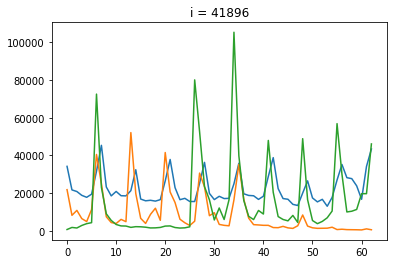

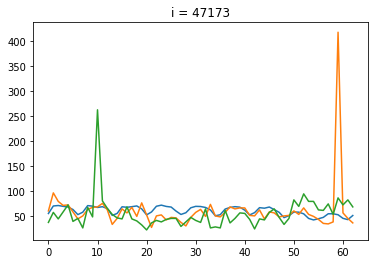

In [195]:
view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), 
                         view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

#### Case 41896

In [202]:
i = 41896

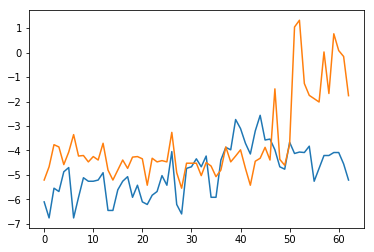

In [203]:
comp_view(X_input[i], Y_input[i])

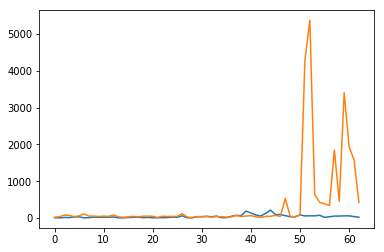

In [204]:
comp_view(X_input_ori[i], Y_input_ori[i])

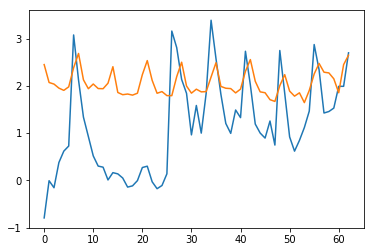

In [205]:
comp_view(X_output[i], Y_output_pred[i])

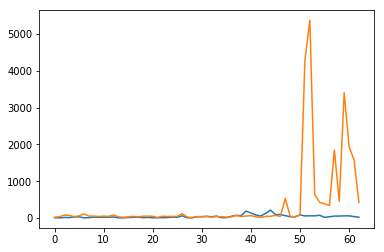

In [206]:
comp_view(X_input_ori[i], Y_input_ori[i])

In [201]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 0.94200805]),
 array([ 0.94200805]),
 array([ 0.17770392]),
 array([ 0.16257146]))

## Output

print('%%% Reading data key_1.csv ...', end = '', flush = True)
output_df = pd.read_csv("../data/key_1.csv")
print('done!')

output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df

output_df.info()

output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

result_df = pd.DataFrame(Y_output_pred_ori, columns = predict_dates_index)
result_df

result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                + '.csv', index = False)
print('done!')

Kaggle Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]